In [127]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from functools import partial
import category_encoders as ce

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

In [4]:
# source: https://www.kaggle.com/abcsds/pokemon
data = pd.read_csv('pokemon.csv')

Predict *Type 1* of a given pokemon since some pokemons don't have *Type 2*

In [15]:
data.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True


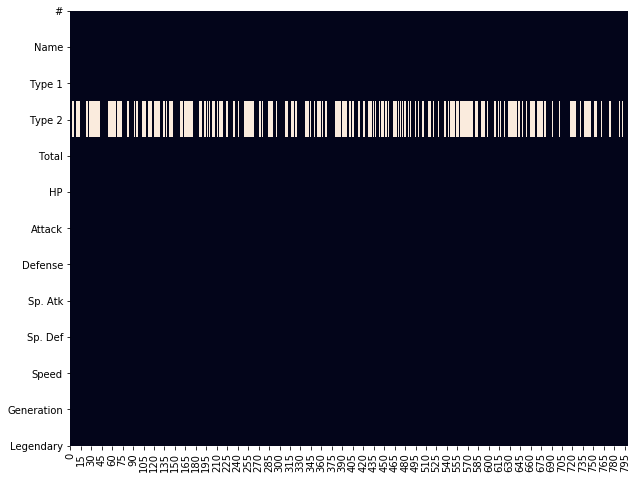

In [26]:
# checking missing data for each feature
plt.figure(figsize=(10,8))
sns.heatmap(data.isnull().T, cbar=False)

<BarContainer object of 13 artists>

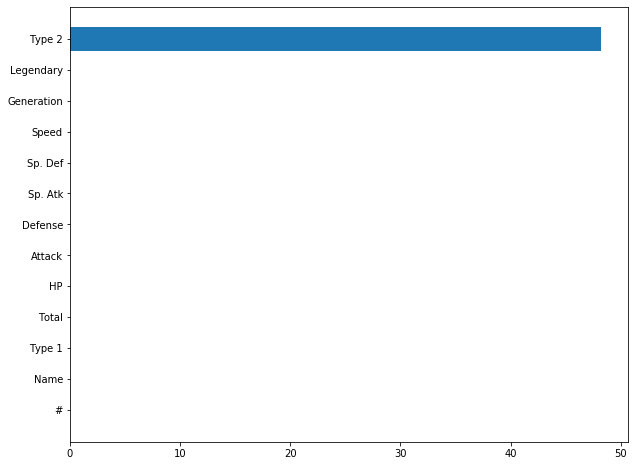

In [27]:
# percentage of missing values per feature
plt.figure(figsize=(10,8))
missing = pd.DataFrame({'column':data.columns ,'na_percent':data.isnull().sum()/len(data)*100})
missing.sort_values('na_percent',inplace=True)
plt.barh(missing['column'],width=missing['na_percent'])

Select relevant columns

In [33]:
data = data[data.columns.difference(['#', 'Name', 'Type 2'])]
data.head()

,Attack,Defense,Generation,HP,Legendary,Sp. Atk,Sp. Def,Speed,Total,Type 1
0,49,49,1,45,False,65,65,45,318,Grass
1,62,63,1,60,False,80,80,60,405,Grass
2,82,83,1,80,False,100,100,80,525,Grass
3,100,123,1,80,False,122,120,80,625,Grass
4,52,43,1,39,False,60,50,65,309,Fire


Dimensionality reduction

Use PCA and TSNE with default parameters, neither can separate pokemon type 1, TSNE can separate if a pokemon is Legendary or not though.

In [100]:
def array_to_df(arr, colname_prefix = 'gene', colnames = None, rownames = None):
    if colnames is None:
        colnames = [colname_prefix+str(i+1) for i in range(arr.shape[1])]
    if rownames is None:
        rownames = [i for i in range(arr.shape[0])]
        
    df=pd.DataFrame(data=arr[0:,0:],
                index=rownames,
                columns=colnames)
    return df

def run_rd(data, method, argument_dict = {}):
    rdm = partial(method, **argument_dict)()
    rd_pipe = Pipeline(steps = [('scaler', StandardScaler()), ('rd', rdm)])
    rd = array_to_df(rd_pipe.fit_transform(data[data.columns.difference(['Type 1'])]), colname_prefix = 'Dim')
    rd['Type1'] = data.reset_index()['Type 1']
    return rd

In [101]:
pca = run_rd(data, method = PCA, argument_dict = {'n_components':2})
tsne = run_rd(data, method = TSNE, argument_dict = {'n_components':2})

Text(0.5, 1.0, 'TSNE')

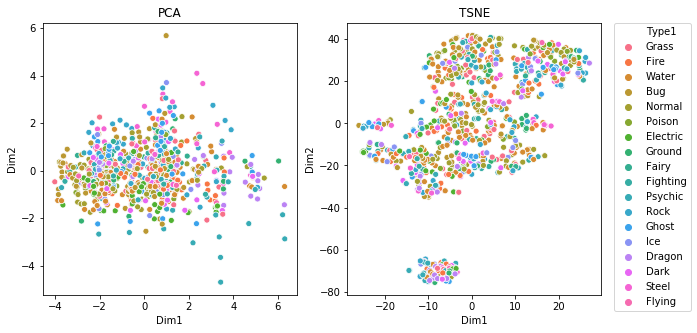

In [126]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.scatterplot(x="Dim1", y="Dim2", data=pca, hue='Type1', legend = False, ax= ax[0])
sns.scatterplot(x="Dim1", y="Dim2", data=tsne, hue='Type1', ax= ax[1])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[0].set_title('PCA')
ax[1].set_title('TSNE')

In [131]:
X_train, X_test, y_train, y_test = \
train_test_split(data[data.columns.difference(['Type 1'])], data['Type 1'], 
                 test_size=0.3, random_state=42, stratify = data['Type 1'])

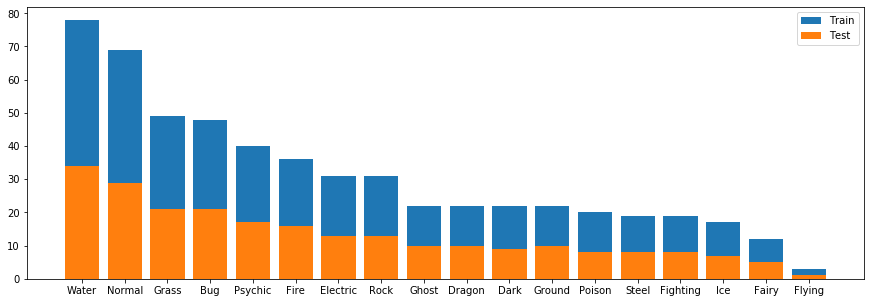

In [157]:
# NOT STACKED barchart, it's Overlapped/Superimposed Barchart
# checking label distributions are similar between train and test
tmp = pd.concat([pd.DataFrame(y_train.value_counts()), 
                 pd.DataFrame(y_test.value_counts())], 
                axis = 1, sort=False).reset_index()
tmp.columns = ['Type1', 'Train', 'Test']
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(tmp.Type1, tmp.Train, label = 'Train')
ax.bar(tmp.Type1, tmp.Test, label = 'Test')
ax.legend()

In [ ]:
def make_models(seed = 0):
    transformer = Pipeline(steps = [('scaler', StandardScaler())])
    LR = Pipeline(steps = [('preprocessing', transformer), 
                           ('classifier', LogisticRegression(class_weight = 'balanced', solver = 'newton-cg'))])
    GNB = Pipeline(steps = [('preprocessing', transformer), 
                            ('classifier', GaussianNB())])
    SVM = Pipeline(steps = [('preprocessing', transformer), 
                            ('classifier', LinearSVC(class_weight='balanced', dual=False, max_iter=5000, random_state=seed))])
    models = {}
    models['LR'] = {'cv': True, 'bagging': False, 'model': LR}
    models['GNB'] = {'cv': True, 'bagging': False, 'model': GNB}
    models['SVM'] = {'cv': True, 'bagging': False, 'model': SVM}
    
    return models 